In [1]:
from data_loader import OpenImagesDataset
from model_utils import device
from model_transformations import Transformations
from torch.utils.data import DataLoader
from params import NUM_EPOCHS, GRID_SIZE,IMAGE_SIZE, NUM_ANCHOR_BOXES, BATCH_SIZE
import torch.optim as optim
import torch
from model_loss import YoloLoss
from tqdm import tqdm
from model import DogDetectorModel
import numpy as np
from model_decoder import Decoder
from non_max_surpression import NonMaxSurpression

In [2]:
# Reading in the training data
trainingData = OpenImagesDataset(rootDirectory='open-images-v6', 
                                 anchorBoxes='centroids.npy', 
                                 transform=Transformations, 
                                 dataType='validation', 
                                 gridSize=GRID_SIZE, 
                                 imageSize=IMAGE_SIZE)    

# Defining the training data
trainDataLoader = DataLoader(dataset=trainingData, 
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

# Reading in the training data
validationData = OpenImagesDataset(rootDirectory='open-images-v6', 
                                 anchorBoxes='centroids.npy', 
                                 transform=Transformations, 
                                 dataType='validation', 
                                 gridSize=GRID_SIZE, 
                                 imageSize=IMAGE_SIZE)    

# Defining the training data
validationDataLoader = DataLoader(dataset=trainingData, 
                             batch_size=30,
                             num_workers=4,
                             shuffle=True)

In [3]:
# Initializing the model
model = DogDetectorModel(gridSize=13, numAnchorBoxes=NUM_ANCHOR_BOXES)

In [4]:
# Moving the model to the GPU
model = model.to(device)

In [5]:
# Defining the optimizer
optimizer = optim.SGD(list(model.parameters()), lr=0.00001, momentum=0.9, weight_decay=0.0005)

In [6]:
lossYolo = YoloLoss('centroids.npy', device)

In [7]:
modelInput, label = trainingData.__getitem__(15)

In [8]:
modelInput = modelInput.reshape((1,3,416,416))

In [9]:
label = label.reshape((1,13,13,35))

In [10]:
# loop =  tqdm(enumerate(trainDataLoader), total=len(trainDataLoader), leave=True)
# for batchIndex, (modelInput, label) in loop:
#     break

In [11]:
bestValidationError = 100000000

for epoch in range(0, NUM_EPOCHS):
    runningLoss = 0.0
    
    # ****************** TRAINING ******************
    
    # Setting the model to training
    model.train()
    
#     loop =  tqdm(enumerate(trainDataLoader), total=len(trainDataLoader), leave=True)
#     for batchIndex, (modelInput, label) in loop:

    # zero the parameter gradients
    optimizer.zero_grad()

    # Moving the model input/label to GPU 
    modelInput = modelInput.to(device)
    label = label.to(device)

    output = model(modelInput)

    loss = lossYolo(output, label)

    loss.backward()
    optimizer.step()

    runningLoss += loss.item()

#     loop.set_description(f"Epoch: [{epoch+1}/{NUM_EPOCHS}]")
#     loop.set_postfix(loss=loss.item())
                
    # ****************** VALIDATION ******************
    
#     # Setting the model to evaluation mode
#     model.eval()
    
#     # Turning of the gradient
#     with torch.no_grad():
        
#         runningValidationError = 0
        
#         loop =  tqdm(enumerate(validationDataLoader), total=len(trainDataLoader), leave=True)
        
#         # Iterating through the batches of the validation data
#         for batchIndex, [modelInput, label] in loop:

#             # Moving the model input/label to GPU 
#             modelInput = modelInput.to(device)
#             label = label.to(device)

#             output = model(modelInput)
            
#             loss = lossYolo(output, label)
            
#             runningValidationError += loss.item()
            
#             loop.set_description(f"Epoch: [{epoch+1}/{NUM_EPOCHS}]")
#             loop.set_postfix(loss=loss.item())
            
#         if runningValidationError < bestValidationError:
#             bestValidationError = runningValidationError
#             torch.save(model.state_dict(), 'yolov2.pt')
#             print('Updated saved model')

        
        
    

In [12]:
d = Decoder('centroids.npy', device)

decodedLabel = d(torch.clone(label), 'label')
decodedOutput = d(torch.clone(output))

In [13]:
nonMaxSurpression = NonMaxSurpression()
predictedBoxes = nonMaxSurpression(decodedOutput)

In [14]:
trueBoxes = nonMaxSurpression(decodedLabel)

In [15]:
from model_utils import plot_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


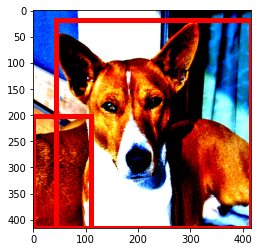

In [17]:
plot_tensor(modelInput[0].cpu(), np.array(trueBoxes[0]))